In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now()}')

Päivitetty 2021-10-30 17:41:00.007361


# Auton hinnan ennustaminen

Olen lainannut ideoita lähteestä https://www.kaggle.com/mohaiminul101/car-price-prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score

%matplotlib inline

## Dataan tutustumista ja muuntamista

In [3]:
df = pd.read_csv('https://taanila.fi/car_data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
# Muunnetaan 'Year' auton iäksi olettaen, että data vuodelta 2020
df['Age'] = 2020 - df['Year']
df = df.drop('Year', axis = 1)

In [7]:
# Pudotetaan 'Car_Name' pois, koska sitä ei tarvita
df = df.drop(labels = 'Car_Name', axis = 1)

In [8]:
df.columns

Index(['Selling_Price', 'Present_Price', 'Kms_Driven', 'Fuel_Type',
       'Seller_Type', 'Transmission', 'Owner', 'Age'],
      dtype='object')

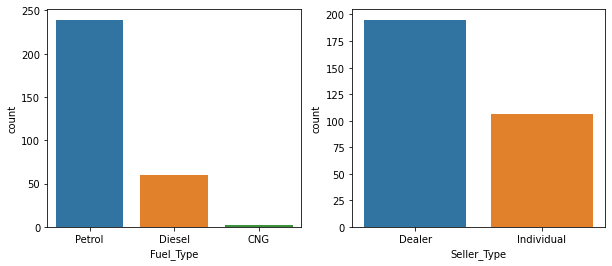

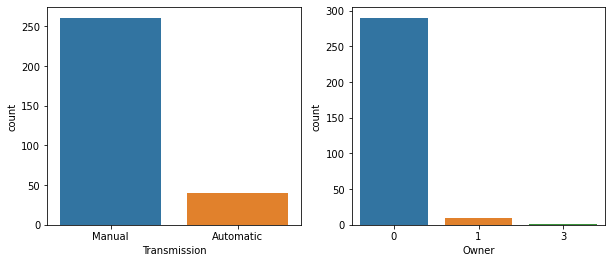

In [9]:
# Kategoristen muuttujien jakaumat

cat_cols = ['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']

for i in range(0, 3, 2):
    fig = plt.figure(figsize = (10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x = cat_cols[i], data = df)
    plt.subplot(1, 2, 2)
    sns.countplot(x = cat_cols[i + 1], data = df)

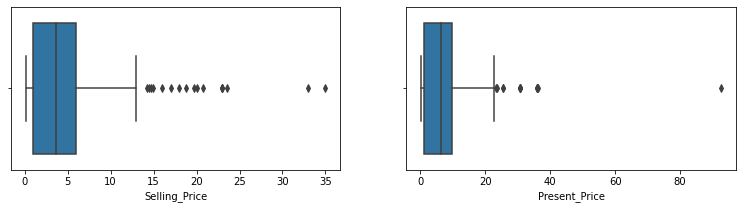

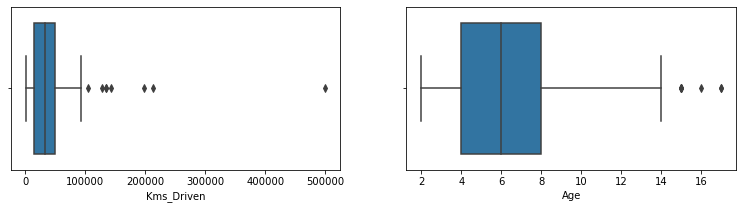

In [10]:
# Määrällisten muuttujien jakaumat

num_cols = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Age']

for i in range(0, 3, 2):
    fig = plt.figure(figsize = (13, 3))
    plt.subplot(1, 2, 1)
    sns.boxplot(x = num_cols[i], data = df)
    plt.subplot(1, 2, 2)
    sns.boxplot(x = num_cols[i + 1], data = df)

<AxesSubplot:>

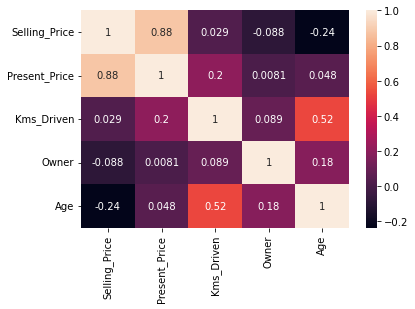

In [11]:
# Korrelaatiot
sns.heatmap(df.corr(), annot = True)

In [12]:
df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,6
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,7
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,3
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,9
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,6


In [13]:
# Kategoriset muuttujat dummy-muuttujiksi
df = pd.get_dummies(data = df, drop_first = True) 

In [14]:
df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,6,0,1,0,1
1,4.75,9.54,43000,0,7,1,0,0,1
2,7.25,9.85,6900,0,3,0,1,0,1
3,2.85,4.15,5200,0,9,0,1,0,1
4,4.60,6.87,42450,0,6,1,0,0,1


## Jako opetus- ja testidataan

In [15]:
# Selittävät muuttujat
X = df.drop('Selling_Price', axis = 1)

# Selitettävä/ennustettava muuttuja
y = df['Selling_Price']

In [16]:
# Jako opetus- ja testidataan
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Mallit

In [17]:
# Funktio mallin sovittamiseen ja arviointiin

R2_train = []
R2_test = []

def mallinna(malli):
    
    # Mallin sovitus opetusdataan
    malli.fit(X_train, y_train)
            
    # Selityskerroin opetusdatalle
    y_pred_train = malli.predict(X_train)
    R2_train_malli = r2_score(y_train,y_pred_train)
    R2_train.append(round(R2_train_malli,2))
    
    # Selityskerroin testidatalle
    y_pred_test = malli.predict(X_test)
    R2_test_malli = r2_score(y_test,y_pred_test)
    R2_test.append(round(R2_test_malli,2))
    
    # Selityskertoimien tulostus
    print("Opetusdatan selityskerroin :",round(R2_train_malli,2))
    print("Testidatan selityskerroin :",round(R2_test_malli,2))
       
    # Opetusdatan virhetermit kaaviona
    fig, ax = plt.subplots(1,2,figsize = (10,4))
    ax[0].set_title('Ennustevirheiden jakauma opetusdatassa')
    sns.histplot((y_train - y_pred_train), kde = True, ax = ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')
    
    # toteutuneet ja ennustetut hajontakaaviona testidatalle
    ax[1].set_title('toteutuneet ja ennustetut testidatassa')
    ax[1].scatter(x = y_test, y = y_pred_test)
    ax[1].set_xlabel('toteutunut')
    ax[1].set_ylabel('ennuste')

### Lineaarinen regressio

Opetusdatan selityskerroin : 0.88
Testidatan selityskerroin : 0.88


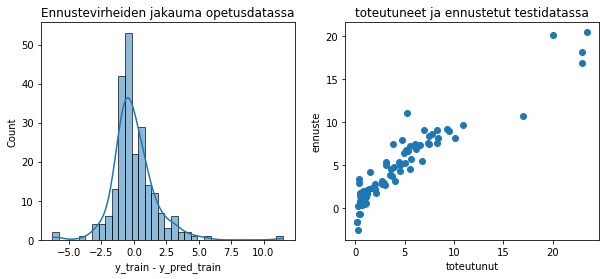

In [18]:
malli = LinearRegression()
mallinna(malli)

### Satunnaismetsä

Opetusdatan selityskerroin : 0.98
Testidatan selityskerroin : 0.96


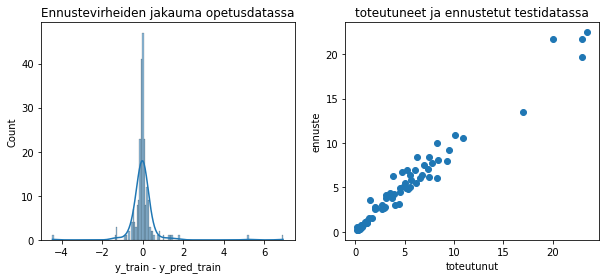

In [19]:
malli = RandomForestRegressor()
mallinna(malli)

### Gradient Boosting

Opetusdatan selityskerroin : 1.0
Testidatan selityskerroin : 0.97


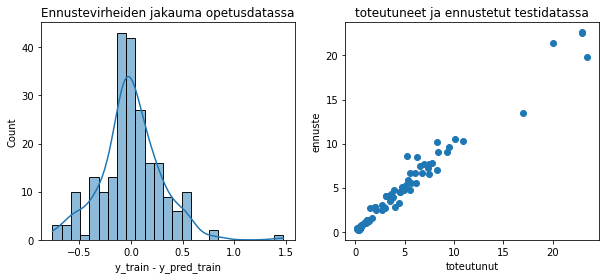

In [20]:
malli = GradientBoostingRegressor()
mallinna(malli)

In [21]:
menetelmä = ["LinearRegression", "RandomForestRegressor", "GradientBoostingRegressor"]
pd.DataFrame({'Malli': menetelmä, 'Selityskerroin (opetusdata)':R2_train, 'Selityskerroin (testidata)':R2_test})

,Malli,Selityskerroin (opetusdata),Selityskerroin (testidata)
0,LinearRegression,0.88,0.88
1,RandomForestRegressor,0.98,0.96
2,GradientBoostingRegressor,1.00,0.97
